## Lesson 3 Feature Engineering and Selection
### Author: Ana Javed

#### Workplace Scenario

A superstore wants to identify customer groupings that visit their stores based on customer transaction (sales) data. These groupings are used for targeted promotions. You are asked to perform customer segmentation on the provided data.

##### Instructions

It is recommended you complete the lab exercises for this lesson before beginning the assignment.

Using the Superstore Transaction dataset, create a new notebook and perform each of the following tasks and answer the related questions:

    - Read dataset
    - Calculate the Recency, Frequency, Monitory for each customer
    - Using K-means algorithm, perform customer segmentation
    - Describe your results


In [325]:
## Importing Necessary Libraries & Packages 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import datetime as dt
import csv
import sklearn 

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.preprocessing import StandardScaler


In [326]:
## Reading data file into Dataframe 
url = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv"
df = pd.read_csv(url, sep=",")

## Top 5 Rows from Dataframe
df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [327]:
## Conducting Exploratory Data Analysis: 
print(df.shape)  # (9994, 21)
print(df.dtypes) # many object types, and few  int64 and float64 types 
print(df.describe()) 

(9994, 21)
Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object
            Row ID   Postal Code         Sales     Quantity     Discount  \
count  9994.000000   9994.000000   9994.000000  9994.000000  9994.000000   
mean   4997.500000  55190.379428    229.858001     3.789574     0.156203   
std    2885.163629  32063.693350    623.245101     2.225110     0.206452   
min       1.000000   1040.000000      0.444000     1.000000     0.000000   
25%    2499.250000  23223.000000     17.280000     2.000000     0.0000

In [328]:
## Converting Order Date and Ship Date to Datetime Objects 

df["Order Date"] = pd.to_datetime(df["Order Date"], format='%m/%d/%Y')
df["Ship Date"] = pd.to_datetime(df["Ship Date"], format='%m/%d/%Y')

# print(df.head(10))

## Printing Max and Min Order and Ship Dates 
print("Minimal Order Date=%s, Maximal Order Date=%s"%(min(df["Order Date"]).strftime("%Y-%m-%d"), \
                                          max(df["Order Date"]).strftime("%Y-%m-%d")))
print("\n")
print("Minimal Ship Date=%s, Maximal Ship Date=%s"%(min(df["Ship Date"]).strftime("%Y-%m-%d"), \
                                          max(df["Ship Date"]).strftime("%Y-%m-%d")))


Minimal Order Date=2014-01-03, Maximal Order Date=2017-12-30


Minimal Ship Date=2014-01-07, Maximal Ship Date=2018-01-05


In [329]:
from collections import OrderedDict

Start_Date_Obj = dt.datetime.strptime("12/01/2017", "%m/%d/%Y")
End_Date_Obj = dt.datetime.strptime("12/30/2017", "%m/%d/%Y")
Time_Window = 90 #days. Only consider customers who have orders within 90 days, or 3 months 
FM_Window = 30 #days for frequency and monetary 

check_point_date = Start_Date_Obj
CustomerID = []
Checkpoint = []
Recency = []
Frequency = []
Monetary_Value = []
Monetary_Quantity = []

while check_point_date <= End_Date_Obj:
    window_start = check_point_date - dt.timedelta(days = Time_Window)
    mask = (df["Order Date"] >= window_start) & (df["Order Date"] < check_point_date)
    # Get the data in [checkpoint-60days, checkpoint]
    data_checkpoint = df.loc[mask]
    # Get the ids of users who have activities in [checkpoint-60days, checkpoint]
    unique_users = list(set(data_checkpoint["Customer ID"]))
    FM_Window_Start = check_point_date - dt.timedelta(days = FM_Window)
    
    print("There are %d unique users"%(len(unique_users)), "for date: ", check_point_date)
    
    for user in unique_users:
        CustomerID.append(user)
        Checkpoint.append(check_point_date)
        
        mask = data_checkpoint["Customer ID"] == user
        data_checkpoint_user = data_checkpoint.loc[mask]
        delta = check_point_date - max(data_checkpoint_user["Order Date"])
        recency = delta.days #Recency, days between checkpoint and last transaction time
        # print(recency)
        
        mask = data_checkpoint_user["Order Date"] >= FM_Window_Start
        data_checkpoint_user_fm = data_checkpoint_user.loc[mask]
        # print(data_checkpoint_user_fm)
        
        frequency = data_checkpoint_user_fm.shape[0] #CustomerID 
        value = np.sum(data_checkpoint_user_fm.iloc[:, 17]) #monetary values - Sales
        quantity = np.sum(data_checkpoint_user_fm.iloc[:, 18])#monetary quantity - Quantity
        
        Recency.append(recency)
        Frequency.append(frequency)
        Monetary_Value.append(value)
        Monetary_Quantity.append(quantity)
        
    check_point_date = check_point_date + dt.timedelta(days = 1)
    
# Consolidate all columns into a signle data frame
RFM_Dict = OrderedDict([ ('Customer ID', CustomerID),
          ('Checkpoint', Checkpoint),
          ('Recency',  Recency),
          ('Frequency', Frequency),
          ('Value', Monetary_Value),
          ('Quantity', Monetary_Quantity)] )

RFM_Frame = pd.DataFrame.from_dict(RFM_Dict)
RFM_Frame.head()


There are 441 unique users for date:  2017-12-01 00:00:00
There are 436 unique users for date:  2017-12-02 00:00:00
There are 440 unique users for date:  2017-12-03 00:00:00
There are 432 unique users for date:  2017-12-04 00:00:00
There are 435 unique users for date:  2017-12-05 00:00:00
There are 440 unique users for date:  2017-12-06 00:00:00
There are 432 unique users for date:  2017-12-07 00:00:00
There are 433 unique users for date:  2017-12-08 00:00:00
There are 433 unique users for date:  2017-12-09 00:00:00
There are 439 unique users for date:  2017-12-10 00:00:00
There are 440 unique users for date:  2017-12-11 00:00:00
There are 445 unique users for date:  2017-12-12 00:00:00
There are 444 unique users for date:  2017-12-13 00:00:00
There are 442 unique users for date:  2017-12-14 00:00:00
There are 440 unique users for date:  2017-12-15 00:00:00
There are 438 unique users for date:  2017-12-16 00:00:00
There are 437 unique users for date:  2017-12-17 00:00:00
There are 439 

,Customer ID,Checkpoint,Recency,Frequency,Value,Quantity
0,BP-11155,2017-12-01,60,0,0.000,0
1,SA-20830,2017-12-01,34,0,0.000,0
2,CS-12400,2017-12-01,18,1,230.376,3
3,DK-13090,2017-12-01,13,5,1105.692,13
4,AS-10630,2017-12-01,63,0,0.000,0


In [330]:
# df.head()
# df.loc[df.loc[:, 'Customer ID'] == 'RB-19570', :]

# len(RFM_Frame["Customer ID"].unique())  # 13129 transactions, 525 unique customers 

### Classifying RFM Dataset 

In [331]:
## Function to Plot the Clusters 
def Plot2DKMeans(Points, Labels, ClusterCentroids, Title, x, y):
    for LabelNumber in range(max(Labels)+1):
        LabelFlag = Labels == LabelNumber
        color =  ['c', 'm', 'y', 'b', 'g', 'r', 'c', 'm', 'y', 'b', 'g', 'r', 'c', 'm', 'y'][LabelNumber]
        marker = ['s', 'o', 'v', '^', '<', '>', '8', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'][LabelNumber]
        try:
            plt.scatter(X.loc[LabelFlag, x], X.loc[LabelFlag,y],
                    s= 100, c=color, edgecolors="black", alpha=0.3, marker=marker)
        except:
            pass
        
#         print(LabelFlag)
#         print(LabelNumber)
        
        if y == 'Recency':
            plt.scatter([LabelNumber], ClusterCentroids[LabelNumber][0], s=200, c="black", marker=marker)
        elif y == 'Frequency':
            plt.scatter([LabelNumber], ClusterCentroids[LabelNumber][1], s=200, c="black", marker=marker)
        elif y == 'Quantity':
            plt.scatter([LabelNumber], ClusterCentroids[LabelNumber][2], s=200, c="black", marker=marker)
            
    plt.title(Title)
    plt.show()


In [332]:
X = RFM_Frame.loc[:, ["Recency", "Frequency", "Quantity"]]

# Z-Normalizing the attributes: 
standardization_scale = StandardScaler().fit(X)
X = standardization_scale.transform(X)
X= pd.DataFrame(X, columns = ["Recency", "Frequency", "Quantity"]) 

# Making sure the attributes are Z-Normalized 
X.describe()

,Recency,Frequency,Quantity
count,1.312900e+04,1.312900e+04,1.312900e+04
mean,1.298882e-17,-8.009774e-17,-3.896647e-17
std,1.000038e+00,1.000038e+00,1.000038e+00
min,-1.410170e+00,-6.920643e-01,-6.384490e-01
25%,-8.219171e-01,-6.920643e-01,-6.384490e-01
50%,-1.944474e-01,-6.920643e-01,-6.384490e-01
75%,7.467572e-01,5.602426e-01,3.858401e-01
max,2.080130e+00,7.447930e+00,6.238921e+00


In [333]:
## Clustering Data with sklearn
kmeans = KMeans(init='random', n_clusters=4, random_state=0).fit(X)  
Labels = kmeans.labels_
ClusterCentroids = kmeans.cluster_centers_

# print(ClusterCentroids)
# print(Labels)

# # Adding Add the K-Means cluster label to the dataset.
X.loc[:,'Labels'] = Labels
RFM_Frame.loc[:,'Labels'] = Labels

u_labels = np.unique(Labels)
print("Unique Labels", u_labels)



Unique Labels [0 1 2 3]


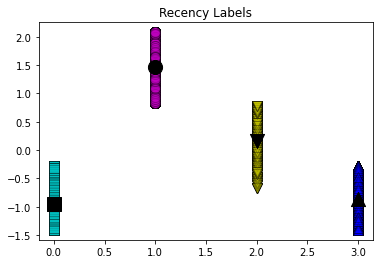

In [334]:
## Cluster Groups by Recency Values
Title = "Recency Labels"
Plot2DKMeans(RFM_Frame, Labels, ClusterCentroids, Title, "Labels", "Recency")


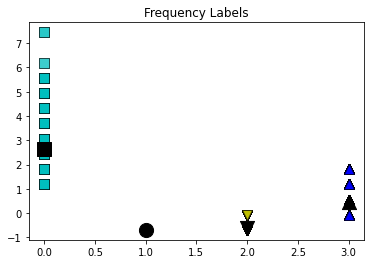

In [335]:
## Cluster Groups by Frequency Values
Title = "Frequency Labels"
Plot2DKMeans(RFM_Frame, Labels, ClusterCentroids, Title, "Labels", "Frequency")


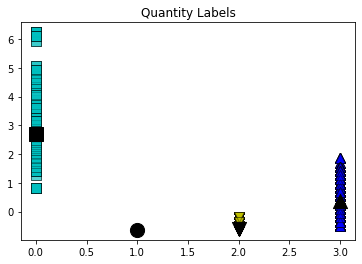

In [336]:
## Cluster Groups by Quantity Values
Title = "Quantity Labels"
Plot2DKMeans(RFM_Frame, Labels, ClusterCentroids, Title, "Labels",  "Quantity")


In [337]:
## Counts by Each Cluster Label 
X.loc[:, "Labels"].value_counts()

3    5091
2    3956
1    3153
0     929
Name: Labels, dtype: int64

#### KMeans Clustering Summary 

Using the superstore transaction data, I sought to identify customer groups using the recency of their online orders, the frequency of their orders, and how many items a customer purchased over a specific range of time (12/01/2017 - 12/30/2017). I only included customers who had at least once purchase in the last 3 months or 90 days, and only counted the number of items a customer purchased in the last month. 
After creating the Recency, Frequency, and Monetary framework for this dataset, I used the K-means algorithm to conduct customer segmentation and create 4 groups of customers across the three attributes.

The results showed 4 customer groups that have a distribution of:
- Label 0 = 929 values  
- Label 1 = 3153 values
- Label 2 = 3956 values
- Label 3 = 5091 values

The 3 plots above display specific differences between the groups. In the Recency plot, Label 1 has a high Recency value (between 2.0 to 0.75), and Label 2 has a moderate Recency value (0.75 to -0.5). Labels 0 and 3 have too much overlap in their Recency values, however the Frequency and Quantity plots show more distinctions between Label 0 and Label 3. Label 0 has higher frequency and quantity values (around 1 to 6), where as Label 3 has much lower frequency and quantity values (around 0 to 2). 

In summary, these are the differences between the four groups:
- Label 0 = Low Recency & High Frequency/Quantity
- Label 1 = High Recency & Low Frequency/Quantity 
- Label 2 = Moderate Recency & Low Frequency/Quantity
- Label 3 = Low Recency & Moderate Frequency/Quantity

